In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import numpyro
import numpy as np 

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive





In [4]:
import jax

jax.config.update("jax_enable_x64", True)

In [5]:
garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]
    print(selected_tracks[0])

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), np.concatenate(yini).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, G_GAIA, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), np.concatenate(MeH).reshape(-1, 1)])



track07294


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [7]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 64)
        self.dense6 = nn.Linear(64, 8)    # Output layer
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)
        return x

    
# Load the pre-trained model weights
model = GarstecNet()
model.load_state_dict(torch.load('garstec_model_V3_state.pth'))

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Dell\AppData\Local\Temp\ipykernel_21824\3765155684.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('garstec_model_V3_state.pth

(910, 7)
[  3.61756117   0.04414762   0.30594305  -1.43583461 -10.
  -1.15539551   0.24572388]


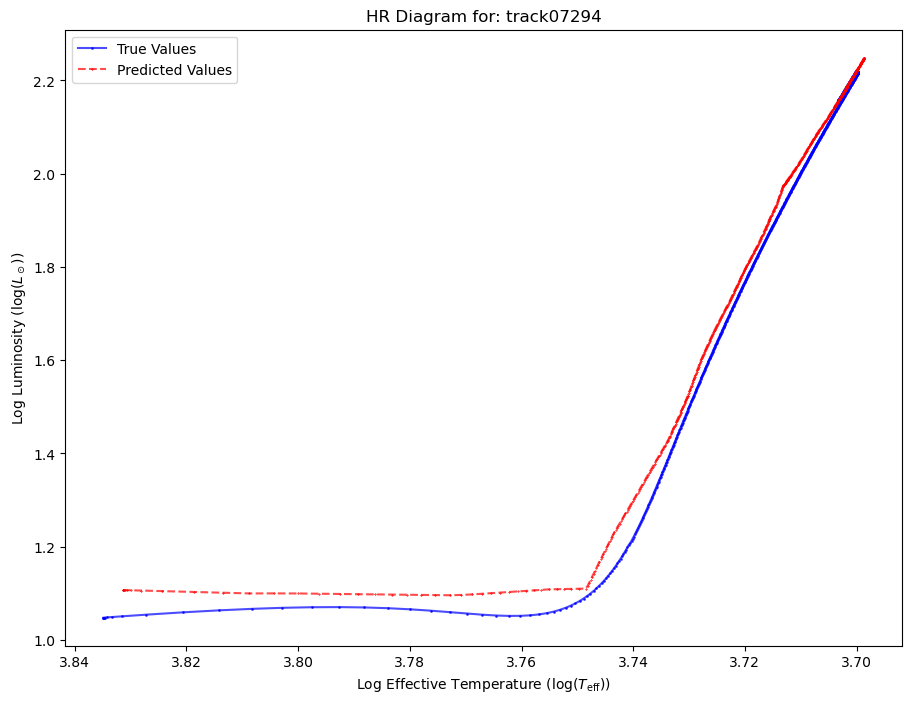

In [ ]:
import jax.numpy as jnp
import h5py
import torch
import matplotlib.pyplot as plt

# Plotting for neural network and garstec track: 07294
specific_track_name = 'track07294'

# Retrieve all required inputs for track 07294
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = jnp.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Outputs
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]
    dnufit_specific = specific_track['dnufit'][:]
    FeH_specific = specific_track['FeH'][:]
    G_GAIA_specific = specific_track['G_GAIA'][:]
    massfin_specific = specific_track['massfin'][:]
    numax_specific = specific_track['numax'][:]
    MeH_specific = specific_track['MeH'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]


# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Convert `all_features` to numpy array before scaling
all_features_numpy = np.array(all_features)  # Convert to numpy for scaling

all_features_scaled = scaler_X.transform(all_features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific1 = model(all_features_tensor).numpy()  # Make predictions
    predictions_specific = scaler_y.inverse_transform(predictions_specific1)  # Inverse transform
# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]



# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()



In [9]:
import jax.numpy as jnp


def emulate_with_pytorch(x, model, scaler_X, scaler_y):
    # Normalize inputs
    x_numpy = np.array(jax.device_get(x))

    x_scaled = scaler_X.transform(x_numpy)  # Apply input scaling

    # Convert to PyTorch tensor
    x_tensor = torch.FloatTensor(x_scaled)

    # Pass through PyTorch model
    model.eval()
    with torch.no_grad():
        y_specific = model(x_tensor).numpy()  # Assuming model output is NumPy array
        

    # Inverse scaling of the output
    y_specific = scaler_y.inverse_transform(y_specific)

    y = jnp.array(y_specific)  # Convert NumPy array to JAX array

    return y_specific 
    

In [10]:

state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x





In [11]:
obs = {
    'teff': teff_specific,
    'lum': luminosity_specific,
    'dnu': dnufit_specific,
    'feh': FeH_specific,
    'gaia': G_GAIA_specific,
    'mass': massfin_specific,
    'numax': numax_specific,
    'meh': MeH_specific
}


In [12]:
def Bmodel(obs=None):
    # Define priors
    ages_ = numpyro.deterministic('ages_', 300 * numpyro.sample("ages_s", dist.Beta(2, 2)) + 4000) 
    massini_ = numpyro.deterministic('massini_', 0.002 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 1.107)  
    fehini_ = numpyro.deterministic('fehini_', 0.02 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 1.15539551)  
    alphamlt_ = numpyro.deterministic('alphamlt_', 0.02 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 2.02275391) 
    yini_ = numpyro.deterministic('yini_', 0.002 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.24572388)  
    eta_ = numpyro.deterministic('eta_', 0.0002 * numpyro.sample("eta_s", dist.Beta(2, 2)) + 0.03665771)  
    alphafe_ = numpyro.deterministic('alphafe_', 0.02 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.21)  



    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, alphafe_]
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.stack(log_transformed_inputs + [fehini_, yini_], axis=-1)
    x = x.reshape(-1, 7)
    
    mean_x = scaler_X.mean_  # Mean for each feature
    scale_x = scaler_X.scale_  # Standard deviation for each feature

    # Manually scale x_numpy
    x_scaled = (x - mean_x) / scale_x



    # Emulate using PyTorch model
    y_scaled = emulate(x_scaled) # , model, scaler_X, scaler_y
    
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y

    # Extract predictions
    teff, lum, dnu, feh, gaia, mass, numax, meh = (
        y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4], y[:, 5], y[:, 6], y[:, 7]
    )

    #print(teff, lum, dnu, feh, gaia, mass, numax, meh) # Test
    # predictions should be: [ 3.8313274   1.1070768   1.5240705   0.22732672  0.02866789 -0.83310765
    # -1.3271372  -1.3964001 ]

    

    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, 50.0), obs=teff_specific)
        numpyro.sample("lum_obs", dist.StudentT(3, lum, 0.05), obs=luminosity_specific)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, 0.8), obs=dnufit_specific)
        numpyro.sample("feh_obs", dist.StudentT(4, feh, 0.02), obs=FeH_specific)
        numpyro.sample("gaia_obs", dist.StudentT(3, gaia, 0.01), obs=G_GAIA_specific)
        numpyro.sample("mass_obs", dist.StudentT(6, mass, 0.6), obs=massfin_specific)
        numpyro.sample("numax_obs", dist.StudentT(4, numax, 0.02), obs=numax_specific)
        numpyro.sample("meh_obs", dist.StudentT(4, meh, 0.02), obs=MeH_specific)


In [13]:
from jax import random
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8,
            init_strategy=init_to_median,  
            find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=4)
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=1)

C:\Users\Dell\AppData\Local\Temp\ipykernel_21824\1851821253.py:7: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 4000/4000 [01:40<00:00, 39.91it/s, 63 steps of size 8.15e-02. acc. prob=0.91] 


In [14]:
import arviz as az

trace = az.from_numpyro(mcmc)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_,4239.937,6.162,4229.752,4251.486,0.103,0.073,3953.0,3730.0,1.0
ages_s,0.800,0.021,0.766,0.838,0.000,0.000,3953.0,3730.0,1.0
alphafe_,-0.200,0.004,-0.208,-0.192,0.000,0.000,8358.0,5350.0,1.0
alphafe_s,0.495,0.222,0.097,0.876,0.002,0.002,8358.0,5350.0,1.0
alphamlt_,2.031,0.004,2.024,2.039,0.000,0.000,6666.0,4109.0,1.0
alphamlt_s,0.406,0.216,0.046,0.797,0.003,0.002,6666.0,4109.0,1.0
eta_,0.037,0.000,0.037,0.037,0.000,0.000,7856.0,4535.0,1.0
eta_s,0.574,0.221,0.186,0.968,0.002,0.002,7856.0,4535.0,1.0
fehini_,-1.136,0.000,-1.137,-1.135,0.000,0.000,6215.0,3808.0,1.0
fehini_s,0.969,0.022,0.930,0.999,0.000,0.000,6215.0,3808.0,1.0


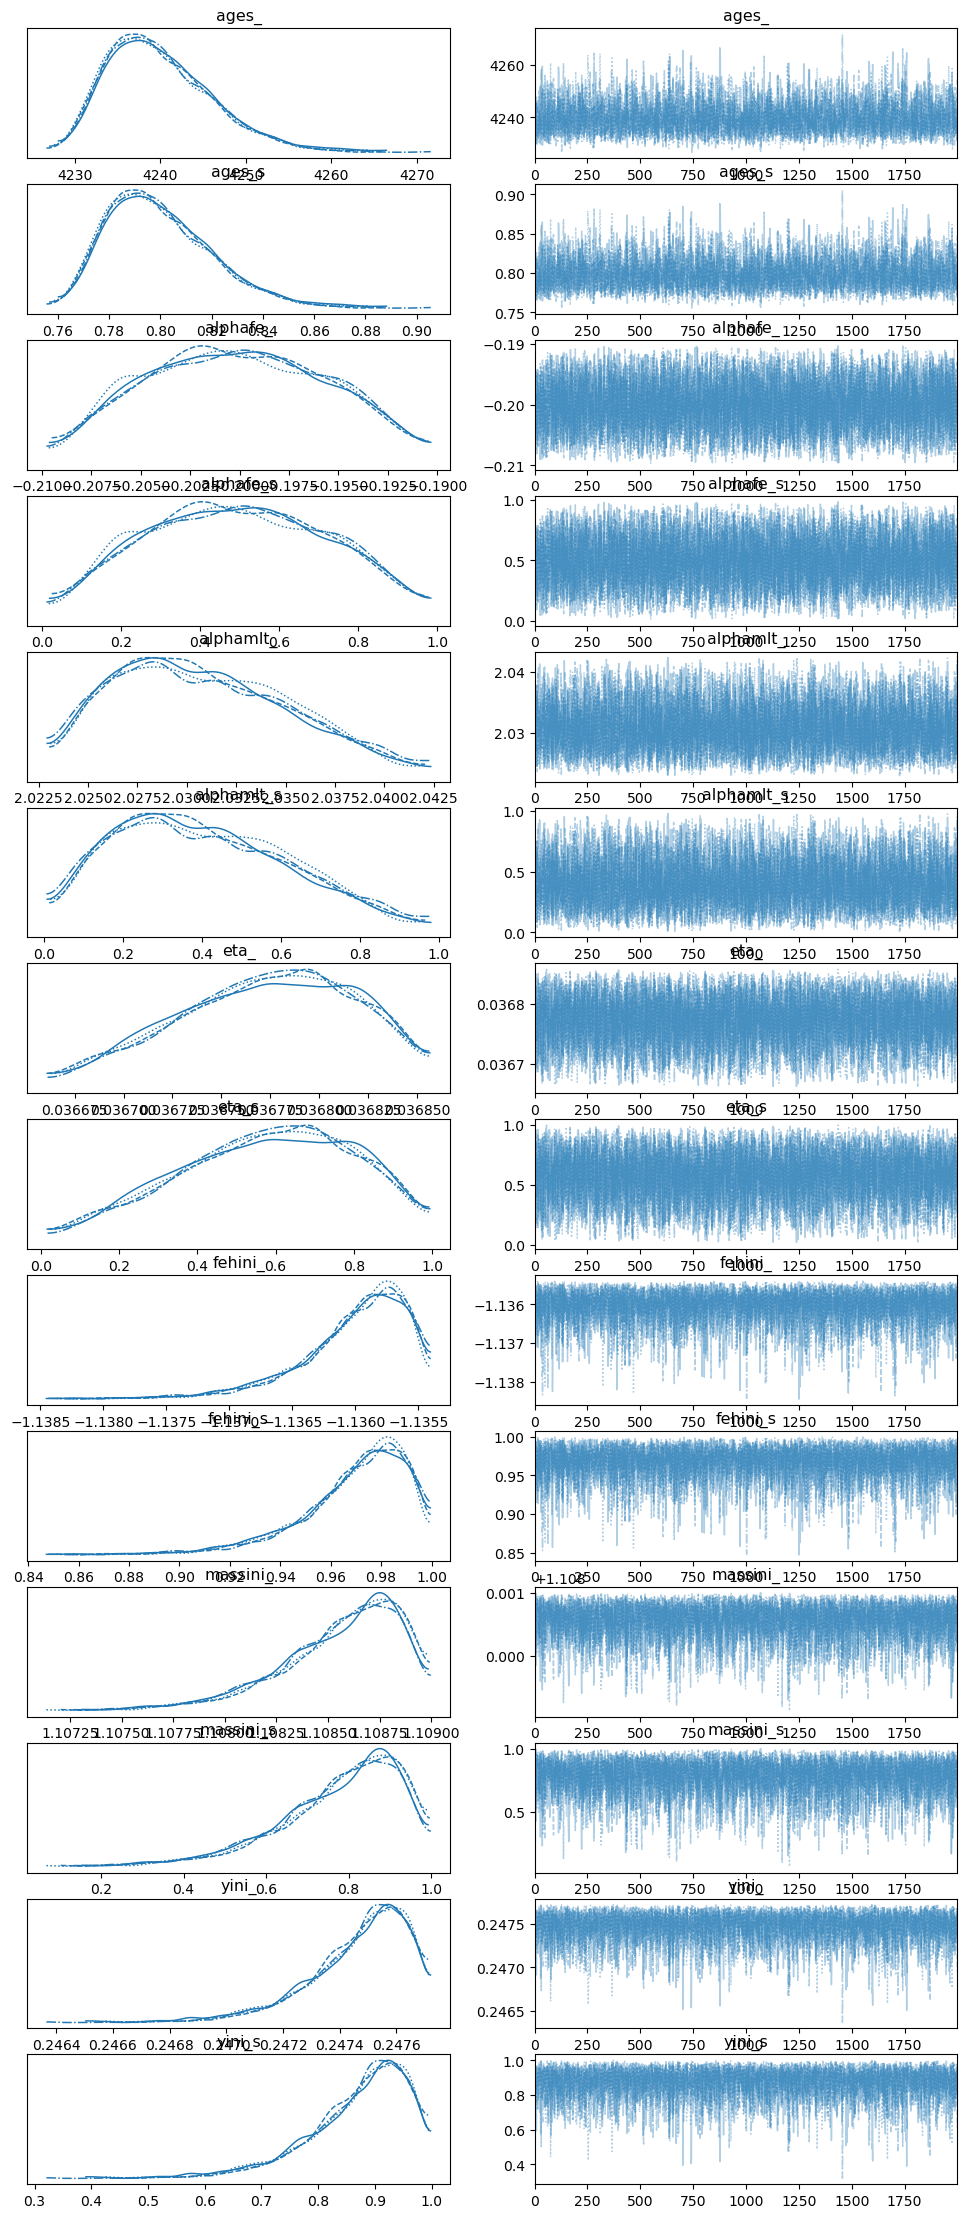

In [15]:
az.plot_trace(trace);

In [16]:
# Setting truth values for corner plot
truth_values = [ages[0].item(), massini[0].item(), alphamlt[0].item(), eta[0].item(), yini[0].item(),  fehini[0].item(), alphafe[0].item()]


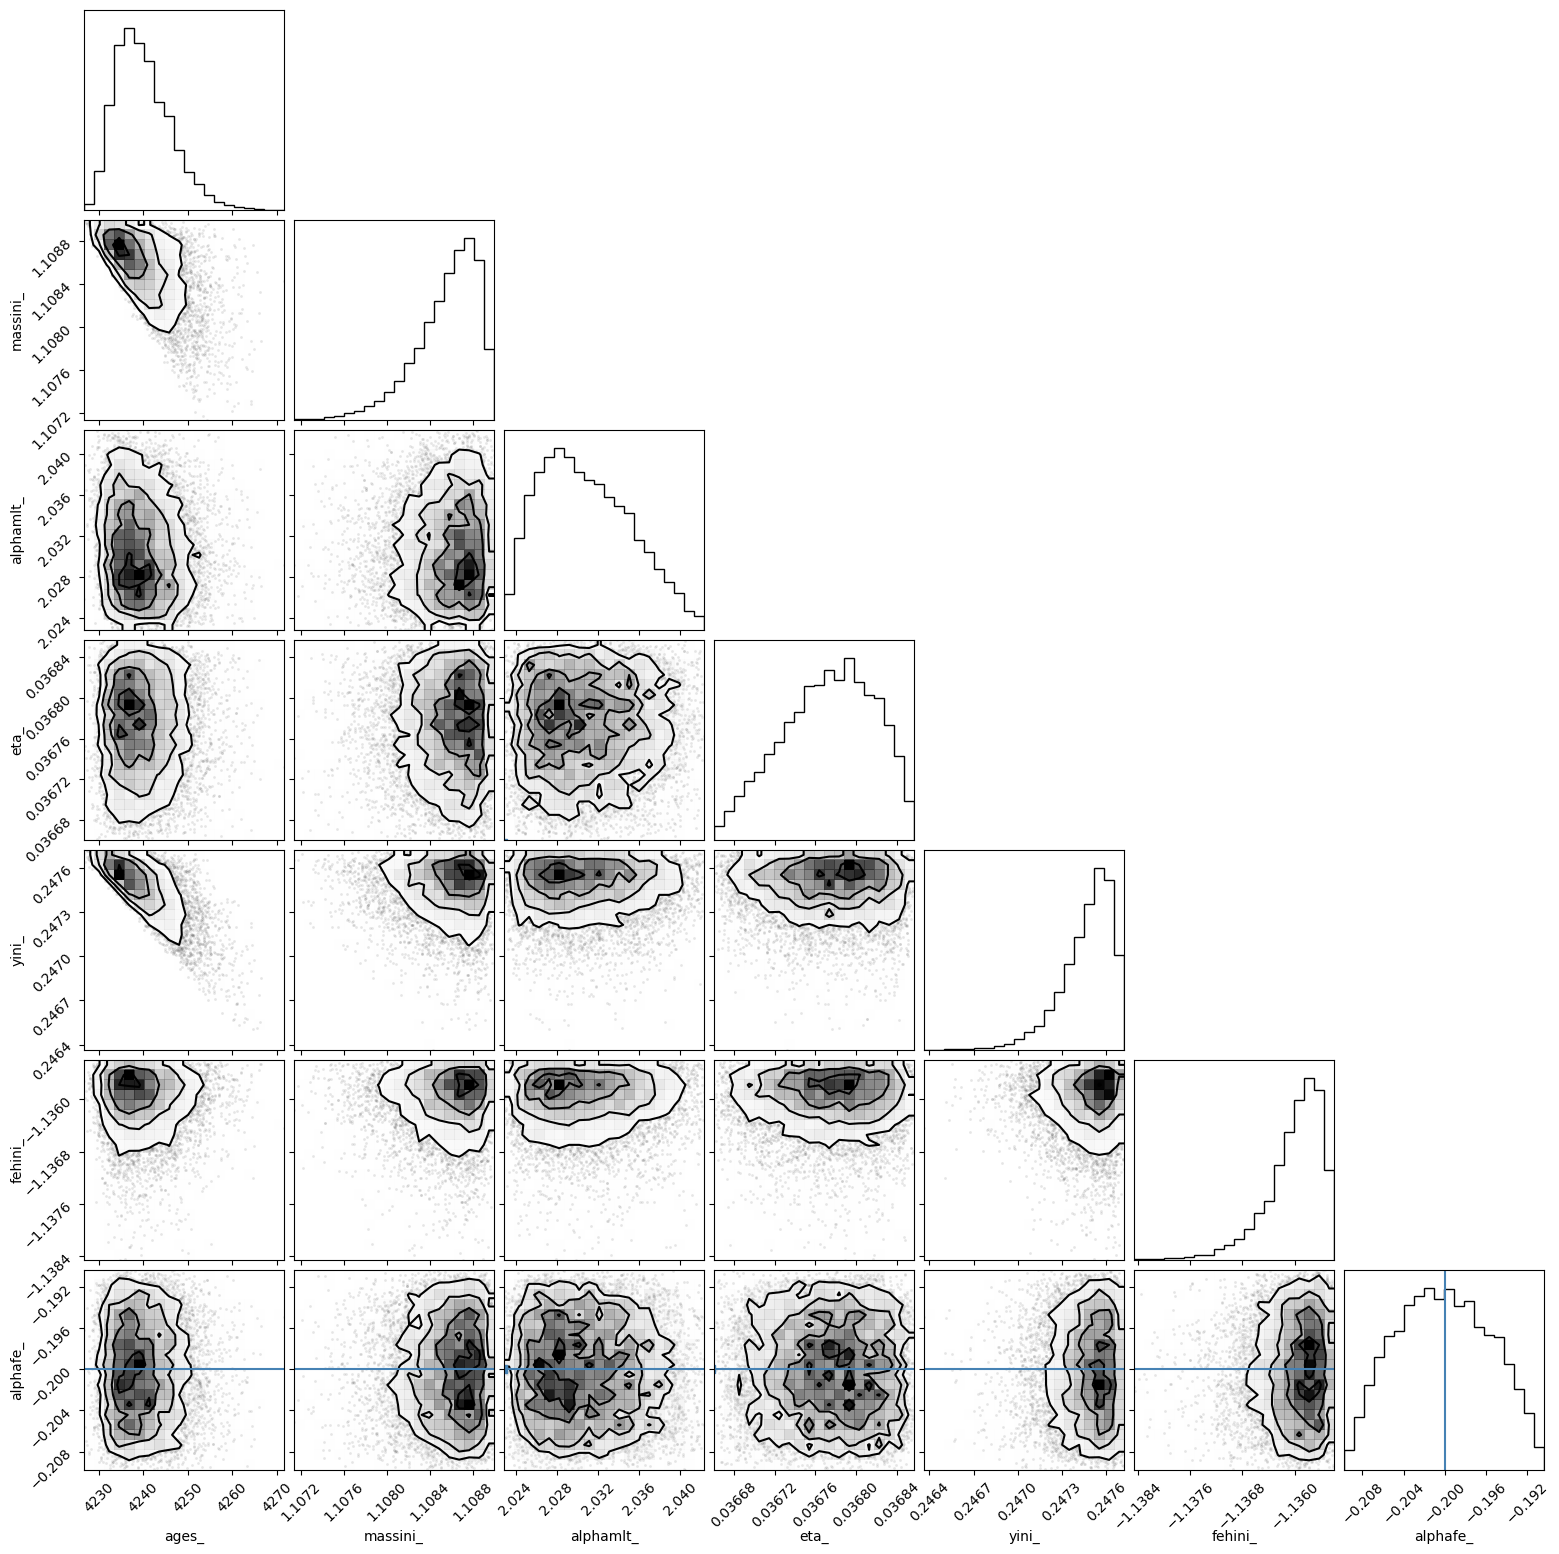

In [17]:
import corner

corner.corner(trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truth_values
             );

In [46]:
# Extract the variables from the trace
ages_samples = trace.posterior['ages_'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()

# Randomly sample 910 indices, ages should have different values but the rest should be single values
ages_indices = np.random.choice(len(ages_samples), size=910, replace=False) # Cutting down number of samples for nn
selected_indices = np.random.choice(len(ages_samples), size=1, replace=False)

# Subsample all variables
ages_subsample = ages_samples[ages_indices]
mass_subsample = np.full(910, mass_samples[selected_indices])
mlt_subsample = np.full(910, mlt_samples[selected_indices])
eta_subsample = np.full(910, eta_samples[selected_indices])
yini_subsample = np.full(910, yini_samples[selected_indices])
fehini_subsample = np.full(910, fehini_samples[selected_indices])
fe_subsample = np.full(910, fe_samples[selected_indices])


log10_hbm_inputs = [ages_subsample, mass_subsample, mlt_subsample, eta_subsample, fe_subsample]
log10_transformed_hbm_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_hbm_inputs]


# Combine log-transformed inputs with raw `fehini` and `yini`
features = np.hstack(log10_transformed_hbm_inputs + [fehini_subsample, yini_subsample]).reshape(-1, 7)

features_numpy = np.array(features)  # Convert to numpy for scaling

features_scaled = scaler_X.transform(features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor

features_tensor = torch.FloatTensor(features_scaled)

print(features.shape)
print(features[2])


(910, 7)
[3.62682005 3.62670633 3.62704668 3.62695033 3.62826867 3.62862321
 3.62692064]


C:\Users\Dell\AppData\Local\Temp\ipykernel_21824\2085323546.py:7: RuntimeWarning: overflow encountered in power
  hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
C:\Users\Dell\AppData\Local\Temp\ipykernel_21824\2085323546.py:8: RuntimeWarning: overflow encountered in power
  hbm_luminosity = 10**predictions_hbm1[:, 1]
C:\Users\Dell\AppData\Local\Temp\ipykernel_21824\2085323546.py:16: RuntimeWarning: divide by zero encountered in log10
  log_hbm_luminosity = np.log10(hbm_luminosity)


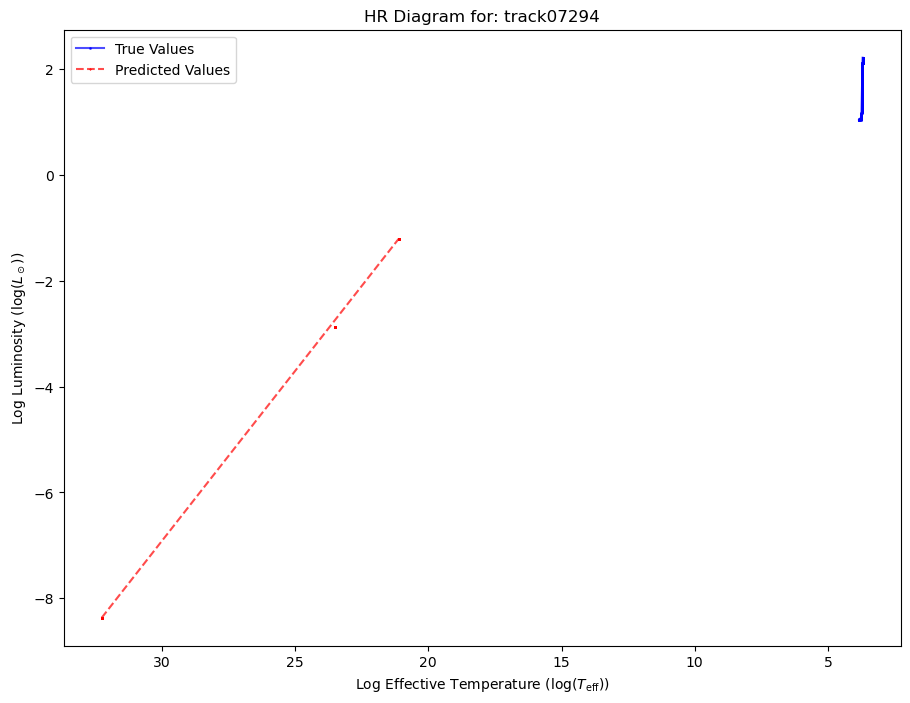

In [51]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm1 = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
hbm_luminosity = 10**predictions_hbm1[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

#print(hbm_teff)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()